In [ ]:
# ## load data
# original_data = pd.read_csv("/kaggle/input/original-creditrisk/credit_risk_dataset.csv")
# df_train0 = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv').drop('id', axis=1)
# df_train = pd.concat([df_train0, original_data])

# ## split features 
# X = df_train.iloc[:, 0:10]
# y = df_train.iloc[:, 11]

# ## train and test set
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=102, 
#     stratify=y,
# )

## pipeline
# num_cols = X_train.select_dtypes(exclude=['object']).columns
# cat_cols = X_train.select_dtypes(include=['object']).columns

# num_pipe = Pipeline(
#     steps=[('scaler', StandardScaler())
     
#     ]
# )

# cat_pipe = Pipeline(
#     steps=[('encoder', OneHotEncoder())
     
#     ]
# )

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('numerical', num_pipe, num_cols),
#         ('categorical', cat_pipe, cat_cols)
#     ]
# )

# combine_all = Pipeline(
#     steps=[
#         ('preprocessor', preprocessor),
#         ('modelo', AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=102))
#     ]
# )

#combine_all

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" 

VER=1

## Load and Train and Test

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

original_data = pd.read_csv("/kaggle/input/original-creditrisk/credit_risk_dataset.csv")
df_train0 = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv').drop('id', axis=1)
df_train = pd.concat([df_train0, original_data])

X = df_train.iloc[:, 0:10]
y = df_train.iloc[:, 11]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=102, 
    stratify=y,
)

In [7]:
df_train.shape

(91226, 12)

## Preprocess

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

num_cols = X_train.select_dtypes(exclude=['object']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# STANDARIZE NUMERICAL FEATURES
print("STANDARDIZING: ",end="")
for c in num_cols:
    print(c,', ',end='')
    m = df_train[c].mean()
    s = df_train[c].std()
    df_train[c] = (df_train[c]-m)/s
    df_train[c] = df_train[c].fillna(0)


# LABEL ENCODE CATEGORICAL FEATURES
CAT_SIZE = []
CAT_EMB = []
RARE = []

print("LABEL ENCODING:")
for c in cat_cols:
    # LABEL ENCODE
    df_train[c],_ = df_train[c].factorize()
    df_train[c] -= df_train[c].min()
    vc = df_train[c].value_counts()
    
    # IDENTIFY RARE VALUES
    RARE.append( vc.loc[vc<40].index.values )
    n = df_train[c].nunique()
    mn = df_train[c].min()
    mx = df_train[c].max()
    r = len(RARE[-1])
    print(f'{c}: nunique={n}, min={mn}, max={mx}, rare_ct={r}')
    
    # RELABEL RARE VALUES AS ZERO
    CAT_SIZE.append(mx+1 +1) #ADD ONE FOR RARE
    CAT_EMB.append( int(np.ceil( np.sqrt(mx+1 +1))) ) # ADD ONE FOR RARE
    df_train[c] += 1
    df_train.loc[df_train[c].isin(RARE[-1]),c] = 0 
    
# PIPELINE
num_pipe = Pipeline(
    steps=[('scaler', StandardScaler())
     
    ]
)

cat_pipe = Pipeline(
    steps=[('encoder', OneHotEncoder())
     
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', num_pipe, num_cols),
        ('categorical', cat_pipe, cat_cols)
    ]
)

STANDARDIZING: person_age , person_income , person_emp_length , loan_amnt , loan_int_rate , loan_percent_income , LABEL ENCODING:
person_home_ownership: nunique=4, min=0, max=3, rare_ct=0
loan_intent: nunique=6, min=0, max=5, rare_ct=0
loan_grade: nunique=7, min=0, max=6, rare_ct=0
cb_person_default_on_file: nunique=2, min=0, max=1, rare_ct=0


## Model

In [13]:
from sklearn.ensemble import AdaBoostClassifier ## model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

stack_stimators = [
    ('cat', CatBoostClassifier(logging_level='Silent')), 
    ('xgb', XGBClassifier()), 
    ('lgb', LGBMClassifier(verbose=0)), 
    ('ext', ExtraTreesClassifier()), ('svc', SVC())]

clf_stack = StackingClassifier(estimators=stack_stimators)

# cl1 = CatBoostClassifier(logging_level='Silent')
# cl2 = XGBClassifier()
# cl3 = LGBMClassifier(verbose=0)
# cl4 = AdaBoostClassifier()
# cl5 = LogisticRegression()

# vcs = VotingClassifier(estimators=[('cat', cl1), ('xgb', cl2), ('lgb', cl3), ('lgr', cl5)], voting='soft')

#params = {'max_leaves': 521, 'logging_level': 'Silent', 'learning_rate': 0.075}

combine_all = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('modelo', CatBoostClassifier(logging_level='Silent', learning_rate=0.075))
    ]
)

scores = cross_val_score(
    combine_all,
    X_train,
    y_train, cv=10, scoring='roc_auc', verbose=4
)

print(f'Roc: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

[CV] END ................................ score: (test=0.963) total time=  11.7s
[CV] END ................................ score: (test=0.957) total time=  11.3s
[CV] END ................................ score: (test=0.959) total time=  11.2s
[CV] END ................................ score: (test=0.950) total time=  11.7s
[CV] END ................................ score: (test=0.953) total time=  11.2s
[CV] END ................................ score: (test=0.953) total time=  11.2s
[CV] END ................................ score: (test=0.959) total time=  11.8s
[CV] END ................................ score: (test=0.961) total time=  11.2s
[CV] END ................................ score: (test=0.965) total time=  11.3s
[CV] END ................................ score: (test=0.956) total time=  11.4s
Roc: 0.958 +/- 0.004


In [ ]:
# n_splits_ = 3
# skf = KFold(n_splits=n_splits_, shuffle=True, random_state=42)

# # rmse_scores = []

# # catboost_params = {
# # #     'learning_rate': 0.075,
# # #     'eval_metric' : 'RMSE',
# # #     'loss_function': 'RMSE',
# # #     'iterations': 5000,
# # #     'depth': 9,
# # #     'random_strength': 0,
# # #     'l2_leaf_reg': 0.5,
# # #     'max_leaves': 512,
# # #     'fold_permutation_block': 64,
# #     'random_seed': 42,
# #     'early_stopping_rounds': 200,
    
# #     'learning_rate': 0.032089785965271685, 
# #     'model_size_reg': 1.1498478100664318, 
# #     'colsample_bylevel': 0.7398749059852404, 
# #     'reg_lambda': 13.481452874196997, 
# #     'n_estimators': 986, 
# #     'max_depth': 10, 
# #     'subsample': 0.5977235262240771, 
# # }

# # xgb_params={
# #      'lambda': 0.03880258557285165,
# #      'alpha': 0.02129832295514386,
# #      'colsample_bytree': 0.4,
# #      'subsample': 0.7,
# #      'learning_rate': 0.014,
# #      'max_depth': 17,
# #      'random_state': 2020,
# #      'min_child_weight': 85,
# #      'n_estimators': 10000,
# #      'early_stopping_rounds': 200,
# # #      'tree_method': 'gpu_hist'
    
# # }

# # lgb_params={
# #                 'num_leaves': 426,
# #                  'max_depth': 20,
# #                  'learning_rate': 0.011353178352988012,
# #                  'n_estimators': 10000,
# #                  'metric': 'rmse',
# #                  'subsample': 0.5772552201954328,
# #                  'colsample_bytree': 0.9164865430101521,
# #                  'reg_alpha': 1.48699088003429e-06,
# #                  'reg_lambda': 0.41539458543414265,
# #                  'min_data_in_leaf': 73,
# #                  'feature_fraction': 0.751673655170548,
# #                  'bagging_fraction': 0.5120415391590843,
# #                  'bagging_freq': 2,
# #                  'random_state': 42,
# #                  'min_child_weight': 0.017236362383443497,
# #                  'cat_smooth': 54.81317407769262,
# #                  'verbose' : -1,
# #                  'early_stopping_rounds': 200,
# # }

# cat_cols = list(categorical_features)  
# test_preds_1 = np.zeros((len(df_test), n_splits_), dtype=np.float32)
# test_preds_2 = np.zeros((len(df_test), n_splits_), dtype=np.float32)
# test_preds_3 = np.zeros((len(df_test), n_splits_), dtype=np.float32)

# cv_scores = []

# #No encoded data for CatBoost (Catboost works better with no encoded data)
# df_test_no_encoded = df_test.copy()

# for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
#     print(f"Fold {fold+1}")
#     X_train, X_val = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
#     X_train_no_encoded = X_train.copy()
#     X_val_no_encoded = X_val.copy()
    
#     df_test_encoded = df_test.copy()
    
#     encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
#     X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
#     X_val[cat_cols] = encoder.transform(X_val[cat_cols])
#     df_test_encoded[cat_cols] = encoder.transform(df_test_encoded[cat_cols])
    
#     print("CB training...")
#     # Train CatBoost
#     model_1 = CatBoostRegressor(**catboost_params, cat_features=cat_cols)
#     model_1.fit(X_train_no_encoded, y_train, eval_set=(X_val_no_encoded, y_val), verbose = 200)
#     val_preds_1 = model_1.predict(X_val_no_encoded)
    
#     print("-"*10)
#     print("XGB training...")
#     # Train XGBoost
#     model_2 = XGBRegressor(**xgb_params)
#     model_2.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=200)
#     val_preds_2 = model_2.predict(X_val)
    
#     # Train Lgbm
#     print("XGB training...")
#     model_3 = LGBMRegressor(**lgb_params)
#     model_3.fit(X_train, y_train, eval_set=[(X_val, y_val)])
#     val_preds_3 = model_3.predict(X_val)
    
#     # Ensemble predictions
#     val_preds_ensemble = (val_preds_2*0.5 + val_preds_3*0.5)
#     score = mean_squared_error(y_val, val_preds_ensemble, squared=False)
#     cv_scores.append(score)
    
#     # Store predictions for test set
#     test_preds_1[:, fold] = model_1.predict(df_test_no_encoded)
#     test_preds_2[:, fold] = model_2.predict(df_test_encoded)
#     test_preds_3[:, fold] = model_3.predict(df_test_encoded)
#     print(f"Fold {fold+1} RMSE: {score}")
#     print('-'*50)

# # Ensemble test predictions by taking the mean
# test_preds_mean = (test_preds_2*0.5 + test_preds_3*0.5)
# test_preds = test_preds_mean.mean(axis=1)

# print(f"Mean RMSE on Eval set: {np.mean(cv_scores)}")

In [ ]:
# ## Test Score
# scores = cross_val_score(
#     combine_all,
#     X_test,
#     y_test, cv=10, scoring='roc_auc', verbose=4
# )

# print(f'Roc: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

In [ ]:
# estimator = [
    
#     MLPClassifier(max_iter = 10000), 
#     LogisticRegression(solver ='lbfgs', multi_class ='multinomial', max_iter = 200),
#     ExtraTreesClassifier(),
#     RandomForestClassifier(),
#     RandomForestClassifier(),
#     SVC(gamma ='auto', probability = True),
#     RandomForestClassifier(),
#     AdaBoostClassifier(),
#     GradientBoostingClassifier(),
#     XGBClassifier(),
#     CatBoostClassifier(logging_level='Silent')
# ]

# mini_estimator = [XGBClassifier(), GradientBoostingClassifier(), CatBoostClassifier(logging_level='Silent')]

## Ensemble

#scores_train = {}
#scores_train = []
# for model in mini_estimator:
#     combine_all = Pipeline(
#         steps=[
#             ('preprocessor', preprocessor),
#             ('modelo', vc)
#         ]
#     )
    
#     ## Train Score
#     scores = cross_val_score(
#         combine_all,
#         X_train,
#         y_train, cv=3, scoring='roc_auc', verbose=0)
    
#     # scores_train[model.__class__.__name__] = np.mean(scores)
#     scores_train.append(np.mean(scores))
    
# print(np.mean(scores_train))

#cl1 = CatBoostClassifier(logging_level='Silent')
#cl2 = XGBClassifier()
#cl3 = LGBMClassifier(verbose=0)

#vc = VotingClassifier(estimators=[('cat', cl1), ('xgb', cl2), ('lgb', cl3)], voting='soft')

# stack_stimators = [
#     ('cat', CatBoostClassifier(logging_level='Silent')), 
#     ('xgb', XGBClassifier()), 
#     ('lgb', LGBMClassifier(verbose=0))
    
# ]

# clf_stack = StackingClassifier(estimators=stack_stimators, final_estimator=LGBMClassifier(verbose=0, boost='dart'))

#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import BaggingClassifier

#base_estimator = CatBoostClassifier(logging_level='Silent')
#bag_ens = BaggingClassifier(estimator=base_estimator, n_estimators=500, max_samples=100,  oob_score=True, random_state=102)

# combine_all = Pipeline(
#     steps=[
#         ('preprocessor', preprocessor),
#         ('modelo', clf_stack)
#     ]
# )

# combine_all

## Ensemble

In [ ]:
# ## Train Score
# scores = cross_val_score(
#     combine_all,
#     X_train,
#     y_train, cv=10, scoring='roc_auc', verbose=4
# )

# print(f'Roc: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

## Fastai

In [ ]:
# from fastai.vision.all import *
# from fastai.text.all import *
# from fastai.collab import *
# from fastai.tabular.all import *

# dls = TabularDataLoaders.from_csv("/kaggle/input/playground-series-s4e10/train.csv", y_names="loan_status",
#     cat_names = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'],
#     cont_names = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income'],
#     procs = [Categorify, Normalize])

# learn = tabular_learner(dls, metrics=accuracy)
# learn.fit_one_cycle(5)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class DiabetesPredictor(nn.Module):
#     def __init__(self):
#         super(df_train, self).__init__()
#         self.fc1 = nn.Linear(8, 16)  # 8 features, 16 neurons in first hidden layer
#         self.fc2 = nn.Linear(16, 16) # 16 neurons in second hidden layer
#         self.output = nn.Linear(16, 1) # Output layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = torch.sigmoid(self.output(x))
#         return x
    

# model = DiabetesPredictor(df_train)
# criterion = nn.BCELoss() # Binary Cross Entropy Loss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# epochs = 100
# for epoch in range(epochs):
#     # Convert arrays to tensors
#     inputs = torch.tensor(X_train, dtype=torch.float32)
#     labels = torch.tensor(y_train, dtype=torch.float32)

#     # Forward pass
#     outputs = model(inputs)
#     loss = criterion(outputs, labels.unsqueeze(1))

#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [ ]:
# ## Test Score
# scores = cross_val_score(
#     combine_all,
#     X_test,
#     y_test, cv=10, scoring='roc_auc', verbose=4
# )

# print(f'Roc: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

## Grid

In [ ]:
# grid = False


# if grid:
#     from sklearn.model_selection import GridSearchCV

#     # Hiperparâmetros para ajuste
#     param_grid = {
#         'modelo__cat__learning_rate': [0.01, 0.1],
#         'modelo__cat__depth': [4, 6],
#         'modelo__xgb__learning_rate': [0.01, 0.1],
#         'modelo__xgb__n_estimators': [100, 200],
#     }

#     # Aplicando GridSearchCV
#     grid_search = GridSearchCV(combine_all, param_grid, cv=10)
#     grid_search.fit(X_train, y_train)

#     # Melhor modelo e parâmetros
#     print("Melhor conjunto de hiperparâmetros:", grid_search.best_params_)
#     print("Melhor precisão:", grid_search.best_score_)

## Optuna

In [ ]:
# %%capture
# !pip install optuna

In [ ]:
# import optuna
# from sklearn.ensemble import VotingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import Pipeline

# # Defina seus classificadores
# cl1 = CatBoostClassifier(verbose=0)  # Defina `verbose=0` para evitar muitos logs
# cl2 = XGBClassifier()

# # Defina o VotingClassifier
# vc = VotingClassifier(estimators=[('cat', cl1), ('xgb', cl2)], voting='soft')

# # Pipeline com pré-processador e modelo
# combine_all = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('modelo', vc)
# ])

# # Definir a função de objetivo para o Optuna
# def objective(trial):
#     # Sugerir hiperparâmetros para CatBoost
#     cat_lr = trial.suggest_float('cat_learning_rate', 0.01, 0.3)
#     cat_depth = trial.suggest_int('cat_depth', 4, 10)
    
#     # Sugerir hiperparâmetros para XGBoost
#     xgb_lr = trial.suggest_float('xgb_learning_rate', 0.01, 0.3)
#     xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 100, 500)

#     # Atualizar parâmetros dos classificadores dentro do VotingClassifier
#     vc.estimators[0][1].set_params(learning_rate=cat_lr, depth=cat_depth)
#     vc.estimators[1][1].set_params(learning_rate=xgb_lr, n_estimators=xgb_n_estimators)

#     # Realizar validação cruzada e retornar a métrica de interesse
#     score = cross_val_score(combine_all, X_train, y_train, cv=5, scoring='accuracy').mean()
    
#     return score

# # Criar o estudo e otimizar
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Resultados
# print("Melhores parâmetros:", study.best_params)
# print("Melhor precisão:", study.best_value)

In [ ]:
# print('Best hyperparameters:', study.best_params)
# print('Best AUC:', study.best_value)

## Learning Curve

In [ ]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=combine_all,
#     X = X_train, 
#     y=y_train,
#     train_sizes=np.linspace(0.1, 1, 10),
#     n_jobs=-1,
#     cv=10
# )

# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)


# # plot
# import matplotlib.pyplot as plt

# plt.plot(train_sizes, train_mean,
#          color='blue', marker='o',
#          markersize=5, label='Training accuracy')

# plt.fill_between(train_sizes,
#                  train_mean + train_std,
#                  train_mean - train_std,
#                  alpha=0.15, color='blue')

# plt.plot(train_sizes, test_mean,
#          color='green', linestyle='--',
#          marker='s', markersize=5,
#          label='Validation accuracy')

# plt.fill_between(train_sizes,
#                  test_mean + test_std,
#                  test_mean - test_std,
#                  alpha=0.15, color='green')

# plt.grid()
# plt.xlabel('Number of training examples')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# #plt.ylim([0.8, 1.03])
# plt.tight_layout()
# plt.show()


## Submit

In [14]:
combine_all = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('modelo', CatBoostClassifier(logging_level='Silent', learning_rate=0.075))
        ]
)
    
combine_all.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'))])),
                ('modelo',
                 <catboost.core.CatBoostClassifier object at 0x79c720cd7e80>)])

In [15]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv').drop('id', axis=1)
sample = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

sample['loan_status'] = combine_all.predict_proba(df_test)[:, 1]
sample.to_csv('#11.csv', index=False)
sample.head()

,id,loan_status
0,58645,0.999398
1,58646,0.032653
2,58647,0.463757
3,58648,0.011917
4,58649,0.030387


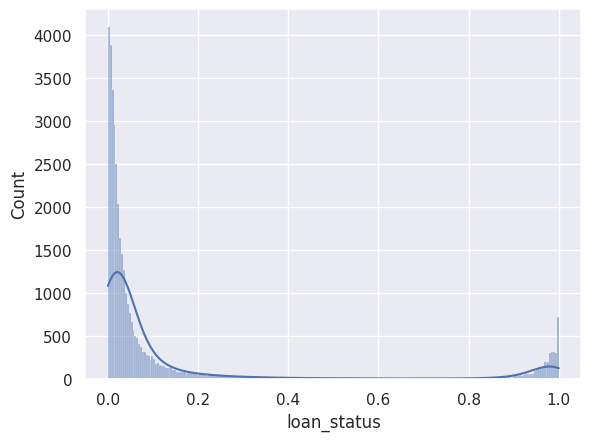

In [16]:
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")
sns.histplot(data=sample, x="loan_status", kde=True);